In [1]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import classification_report
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

In [77]:
# tenemos 3 set datos con los cuales trabajaremos
bluevsred = pd.read_csv('2020_bluevsred.csv')
redvsblue = pd.read_csv('2020_redvsblue.csv')

In [5]:
#Feature engineering

In [6]:
numeric2teams = bluevsred._get_numeric_data()
numeric2teams

,year,playoffs,game,patch,playerid,gamelength,result,blue_kills,blue_deaths,blue_ assists,...,red_csat10,red_golddiffat10,red_xpdiffat10,red_csdiffat10,red_goldat15,red_xpat15,red_csat15,red_golddiffat15,red_xpdiffat15,red_csdiffat15
0,2020,0,1,9.24,100,2220,1,17,11,33,...,322.0,-117.0,137.0,-8.0,22778.0,28884.0,519.0,825.0,1665.0,12.0
1,2020,0,2,9.24,100,2227,0,5,21,16,...,334.0,2014.0,2149.0,34.0,27198.0,31702.0,557.0,5484.0,4833.0,56.0
2,2020,0,3,9.24,100,1711,1,21,4,34,...,340.0,-682.0,-615.0,-25.0,22316.0,28252.0,531.0,-2566.0,-2097.0,-53.0
3,2020,0,4,9.24,100,1999,0,4,17,8,...,329.0,1579.0,858.0,21.0,24800.0,29157.0,535.0,2471.0,3064.0,70.0
4,2020,0,1,9.24,100,1812,0,3,21,7,...,325.0,747.0,313.0,-12.0,23767.0,29371.0,524.0,-877.0,-205.0,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,2020,1,4,10.16,100,1876,0,14,25,23,...,310.0,881.0,-657.0,-1.0,25854.0,29325.0,473.0,1280.0,815.0,24.0
5471,2020,1,1,10.16,100,1841,0,8,20,16,...,316.0,-658.0,-742.0,-31.0,24827.0,28963.0,535.0,567.0,315.0,-7.0
5472,2020,1,2,10.16,100,1597,1,15,5,31,...,329.0,-606.0,-392.0,9.0,23629.0,28518.0,486.0,-1600.0,-1291.0,-1.0
5473,2020,1,3,10.16,100,1766,1,18,3,37,...,304.0,-1862.0,-1252.0,-45.0,22681.0,28496.0,498.0,-2793.0,-1547.0,-41.0


In [8]:
numeric2teams.isnull().sum()

year                 0
playoffs             0
game                 0
patch                0
playerid             0
                    ..
red_xpat15          71
red_csat15          71
red_golddiffat15    71
red_xpdiffat15      71
red_csdiffat15      71
Length: 130, dtype: int64

In [9]:
# rellenando nan values
numeric2teams.fillna(numeric2teams.mean(), inplace=True)
numeric2teams.isnull().sum()

year                0
playoffs            0
game                0
patch               0
playerid            0
                   ..
red_xpat15          0
red_csat15          0
red_golddiffat15    0
red_xpdiffat15      0
red_csdiffat15      0
Length: 130, dtype: int64

In [11]:
# tirando columnas totalmente vacias
numeric2teams.dropna(axis=1, how='all', inplace=True)

In [13]:
# change int64 to int 32
numeric2teams32 = numeric2teams.astype(np.float32)

In [14]:
variable_y = numeric2teams32['result']
variables_x = numeric2teams32.loc[:, numeric2teams32.columns != 'result']

In [15]:
# Separa en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(variables_x, variable_y, test_size=0.2)#, random_state=0) (quitar parentesis)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4380, 129) (4380,) (1095, 129) (1095,)


In [16]:
#primeros entrenamientos
clasif = RandomForestClassifier(n_jobs=2, random_state=0)
clasif.fit(X_train, y_train)

RandomForestClassifier(n_jobs=2, random_state=0)

In [17]:
preds = clasif.predict(X_test)

In [18]:
pd.crosstab(y_test, preds, rownames=['Resultado Real'], colnames= ['Resultados predichos'])

Resultados predichos,0.0,1.0
Resultado Real,,
0.0,506,2
1.0,4,583


In [19]:
# observamos que con esta regresion obtenemos una gran aproximacion
roc_auc_score(y_test, preds)

0.9946243410374385

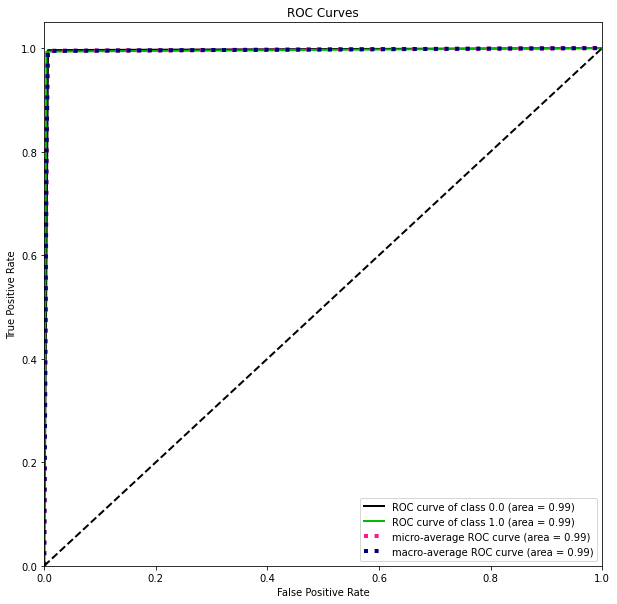

In [20]:
y_prob = np.concatenate(((1-preds).reshape(-1,1),preds.reshape(-1,1)), axis =1)
skplt.metrics.plot_roc(y_test, y_prob,figsize=(10,10))
plt.show()

In [21]:
# aplicaremos un modelo de logistico de regresión
# volvienod a separar en 4 el data set
X_train, X_test, y_train, y_test = train_test_split(variables_x, variable_y, test_size=0.2) 
# Separa en 80% train y 20% test

In [22]:
logreg = LogisticRegression() # aqui ponemos todos los argumentos necesarios, si los tenemos
# aqui hacemos la instancia de nuestro modelo
logreg.fit(X_train,y_train) # despues lo entrenamos

C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
y_pred = logreg.predict(X_test)
print(f'La precision de nuestro modelo de clasificacion de regresion logistica es: {logreg.score(X_test, y_test)}')

La precision de nuestro modelo de clasificacion de regresion logistica es: 0.9926940639269406


In [24]:
# aplicando un escalado
#x = data.values --------> esta no sirve por que tiene todo el dataset
x = variables_x.values #----------> este solo incluye las 20 observaciones, son las como las preguntas del examen
x = scale(x)

C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [26]:
# usamos PCA para una reduccion de columnas
len(numeric2teams32.columns)

130

In [30]:
# para saber cual es la cantidad de features que hay que pasar
covar_matrix = PCA(n_components=129)

In [31]:
covar_matrix.fit(x) # metemos las observaciones
varianza = covar_matrix.explained_variance_ratio_

var = np.cumsum(np.round(varianza, decimals=3)*100)
# no debe empezar con el 100%

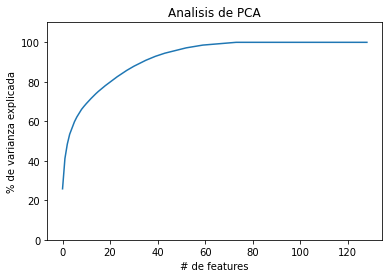

In [32]:
plt.ylabel('% de varianza explicada')
plt.xlabel('# de features')
plt.title('Analisis de PCA')
plt.ylim(0, 110)
plt.plot(var)

In [33]:
# para saber cual es la mejor feature
# simulando que la grafica se corta a los 20 componentes
pca = PCA(n_components=20)
seleccion = SelectKBest(k=1)

featureCombinada = FeatureUnion([('pca',pca),('seleccion universal', seleccion)])

X_features = featureCombinada.fit(variables_x, variable_y).transform(x)
print(f'El espacio combinado tiene {X_features.shape[1]} features')

El espacio combinado tiene 21 features


C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [34]:
X_train, X_test, y_train, y_test = train_test_split(variables_x, variable_y, test_size=0.2) 
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4380, 129) (1095, 129) (4380,) (1095,)


In [35]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(f'La precision de nuestro modelo de clasificacion de regresion logistica es: {logreg.score(X_test, y_test)}')
pd.crosstab(y_test, preds, rownames=['Resultado Real'], colnames= ['Resultados predichos'])

La precision de nuestro modelo de clasificacion de regresion logistica es: 0.9908675799086758


C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados predichos,0.0,1.0
Resultado Real,,
0.0,245,282
1.0,265,303


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       527
         1.0       0.99      0.99      0.99       568

    accuracy                           0.99      1095
   macro avg       0.99      0.99      0.99      1095
weighted avg       0.99      0.99      0.99      1095



<AxesSubplot:>

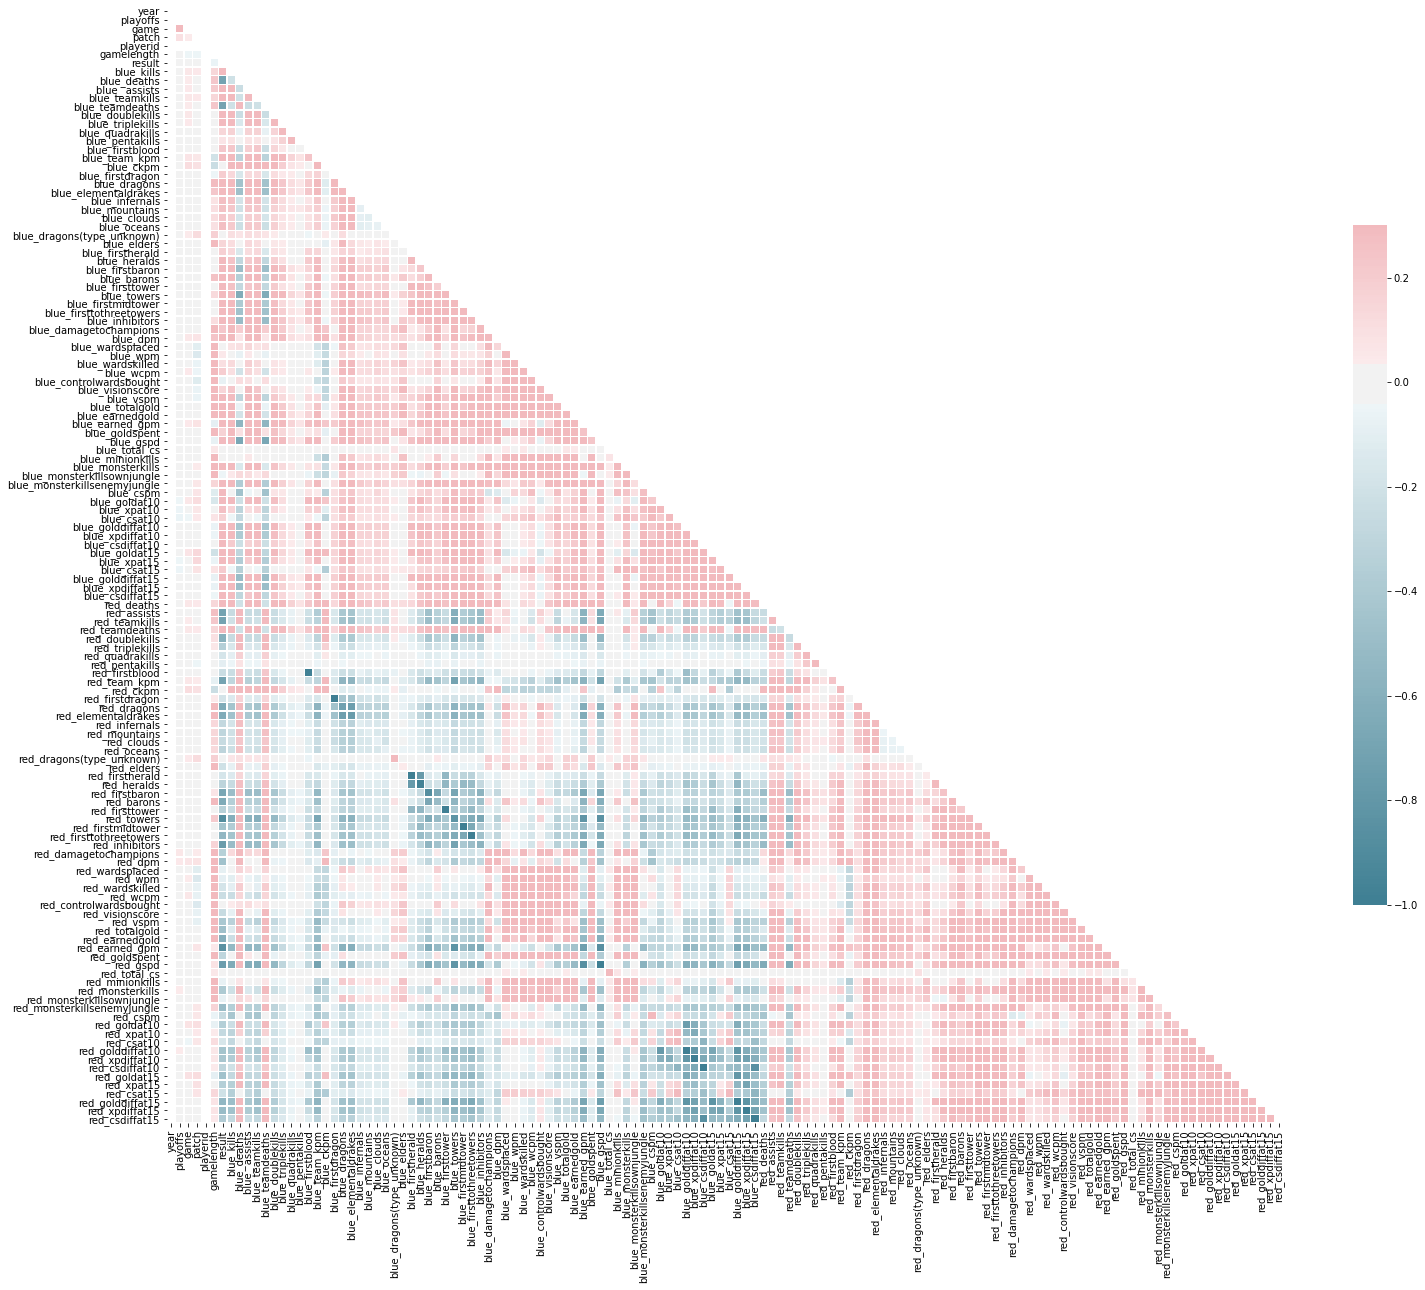

In [39]:
# como parte de esta extraccion de features, hacer una matriz de correlacion para saber que afecta mas
# ocupando todos los datos
corr=numeric2teams32.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(25,25))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.columns.values,yticklabels=corr.columns.values)


In [42]:
# quitamos columnas que podrían no brindan información util
variables_x, variable_y = numeric2teams32.drop(['result', 'year', 'playoffs'], axis = 1), numeric2teams32['result']
# despues de esto volvemos hacer todo el proceso

X_train, X_test, y_train, y_test = train_test_split(variables_x, variable_y, test_size=0.2) 
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(f'La precision de nuestro modelo de clasificacion de regresion logistica es: {logreg.score(X_test, y_test)}')
pd.crosstab(y_test, preds, rownames=['Resultado Real'], colnames= ['Resultados predichos'])

# subio ligeramente la precisión, en un .001%

(4380, 127) (1095, 127) (4380,) (1095,)
La precision de nuestro modelo de clasificacion de regresion logistica es: 0.9917808219178083


C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados predichos,0.0,1.0
Resultado Real,,
0.0,236,285
1.0,274,300


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       521
         1.0       0.99      0.99      0.99       574

    accuracy                           0.99      1095
   macro avg       0.99      0.99      0.99      1095
weighted avg       0.99      0.99      0.99      1095



In [47]:
# usando chi2
# debido a que no acepta valores negativos el metodo chi2, los quitaremos
numeric2teams32.columns[(numeric2teams32 < 0).any()]

Index(['blue_gspd', 'blue_golddiffat10', 'blue_xpdiffat10', 'blue_csdiffat10',
       'blue_golddiffat15', 'blue_xpdiffat15', 'blue_csdiffat15', 'red_gspd',
       'red_golddiffat10', 'red_xpdiffat10', 'red_csdiffat10',
       'red_golddiffat15', 'red_xpdiffat15', 'red_csdiffat15'],
      dtype='object')

In [48]:
variables_x, variable_y = numeric2teams32.drop(['result', 'year', 'playoffs','blue_gspd', 'blue_golddiffat10', 'blue_xpdiffat10', 'blue_csdiffat10',
       'blue_golddiffat15', 'blue_xpdiffat15', 'blue_csdiffat15', 'red_gspd',
       'red_golddiffat10', 'red_xpdiffat10', 'red_csdiffat10',
       'red_golddiffat15', 'red_xpdiffat15', 'red_csdiffat15'], axis = 1), numeric2teams32['result']

In [49]:
selector_chi2 = SelectKBest(chi2, k=20)
X_kbest = selector_chi2.fit_transform(variables_x, variable_y)
print(f'Numero de features originalmente {variables_x.shape[1]}')
print(f'Numero de features reducidas {X_kbest.shape[1]}')

Numero de features originalmente 113
Numero de features reducidas 20


In [50]:
# método wrapper para feature selection, interaccion que existen entre las diferentes variables
# Recursive Feature Elimination, igual otro método
clf = RandomForestClassifier(n_jobs=2, random_state=0)
rfe = RFE(clf, 20)
rfe = rfe.fit(variables_x, variable_y)
print(rfe.support_)
print(rfe.ranking_)

C:\Users\Efrain\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[False False False False  True  True  True False  True False False False
 False False  True False False False False False False False False False
 False False False False False False  True False False  True False False
 False False False False False False False False  True  True False False
 False False False False False False False False False False False  True
  True  True  True False False False False False  True False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False  True  True  True False False False False False False False False
 False False False False False]
[81 55 94 20  1  1  1  2  1 18 63 80 88 87  1 13 85 12 31 75 71 77 67 62
 61 92 76 48 29 86  1 74 64  1 10  8 32 49 25 42 44 23 51  3  1  1  9 91
 60 16 52  4 14 50 28 53 24 35 57  1  1  1  1 43 69 65 78 89  1  6 82  7
 26 68 72 70 66 58 56 90 79 27  1 84  1 83 73  1 15 17 30 47 41 37 39 46
 19  1  1  1  5 93 

In [51]:
# vamos a ver cada una de las importancia de las columnas
modelo = RandomForestClassifier(n_jobs=2, random_state=0)
modelo.fit(variables_x, variable_y)
print(modelo.feature_importances_)

[1.61495968e-04 2.53429075e-04 0.00000000e+00 8.54487253e-04
 1.67503381e-02 5.41049949e-02 1.87753341e-02 1.31641485e-02
 3.86867227e-02 5.48975382e-03 3.83801954e-04 1.20697523e-04
 1.11054422e-04 8.54546949e-05 2.45920827e-02 2.60062503e-03
 5.58920558e-05 1.83180292e-03 4.13108015e-03 1.81033689e-04
 2.29083336e-04 2.05284904e-04 1.26264630e-04 4.43816582e-04
 3.04939013e-04 9.37403524e-05 2.26479279e-04 5.05240010e-03
 6.31758900e-03 8.90747641e-05 9.82898317e-02 1.92835691e-03
 2.35758214e-04 1.01014701e-01 2.45387246e-03 4.73275385e-03
 7.14868753e-04 5.86218794e-04 6.01968420e-04 7.35090330e-04
 7.43455988e-04 1.21378864e-03 7.13958972e-04 2.44521306e-03
 1.09625177e-02 7.50310507e-02 9.81914998e-04 5.15886489e-05
 6.95864970e-04 1.03717897e-03 5.43982131e-04 1.06160883e-03
 8.35653906e-04 6.20232968e-04 4.50991904e-04 5.38327004e-04
 8.05805722e-04 5.01824338e-04 6.35254701e-04 1.67797167e-02
 1.44947427e-02 4.47912117e-02 3.48038632e-02 1.29386408e-03
 2.68352027e-04 1.699022

In [52]:
# ocuparemos Gini-importance para saber cuales son esos features 
features = {}
for feature, importancia in zip(variables_x.columns, modelo.feature_importances_):
    features[feature] = importancia
    
importancias = pd.DataFrame.from_dict(features, orient='index').rename(columns={0:'Gini-importance'})
importancias.sort_values(by='Gini-importance', ascending = False).head(20)

,Gini-importance
red_towers,0.121223
blue_inhibitors,0.101015
blue_towers,0.098290
red_inhibitors,0.078169
blue_earned_gpm,0.075031
red_earned_gpm,0.067547
blue_deaths,0.054105
red_teamkills,0.044791
blue_teamdeaths,0.038687
red_teamdeaths,0.034804


In [53]:
# usando XGBOOST-----------------------------------------

In [153]:
x_cols = list(variables_x.columns)

In [165]:
variables_x, variable_y = numeric2teams32.drop(['result', 'year', 'playoffs','blue_gspd', 'blue_golddiffat10', 'blue_xpdiffat10', 'blue_csdiffat10',
       'blue_golddiffat15', 'blue_xpdiffat15', 'blue_csdiffat15', 'red_gspd',
       'red_golddiffat10', 'red_xpdiffat10', 'red_csdiffat10',
       'red_golddiffat15', 'red_xpdiffat15', 'red_csdiffat15'], axis = 1), numeric2teams32['result']

In [166]:
data_dmatrix = xgb.DMatrix(data=variables_x,label=variable_y)
X_train, X_test, y_train, y_test = train_test_split(variables_x, variable_y, test_size=0.2, random_state=123)

In [167]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [172]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[03:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [211]:
list(X_test.columns)

['game',
 'patch',
 'playerid',
 'gamelength',
 'blue_kills',
 'blue_deaths',
 'blue_ assists',
 'blue_teamkills',
 'blue_teamdeaths',
 'blue_doublekills',
 'blue_triplekills',
 'blue_quadrakills',
 'blue_pentakills',
 'blue_firstblood',
 'blue_team_kpm',
 'blue_ckpm',
 'blue_firstdragon',
 'blue_dragons',
 'blue_elementaldrakes',
 'blue_infernals',
 'blue_mountains',
 'blue_clouds',
 'blue_oceans',
 'blue_dragons(type_unknown)',
 'blue_elders',
 'blue_firstherald',
 'blue_heralds',
 'blue_firstbaron',
 'blue_barons',
 'blue_firsttower',
 'blue_towers',
 'blue_firstmidtower',
 'blue_firsttothreetowers',
 'blue_inhibitors',
 'blue_damagetochampions',
 'blue_dpm',
 'blue_wardsplaced',
 'blue_wpm',
 'blue_wardskilled',
 'blue_wcpm',
 'blue_controlwardsbought',
 'blue_visionscore',
 'blue_vspm',
 'blue_totalgold',
 'blue_earnedgold',
 'blue_earned_gpm',
 'blue_goldspent',
 'blue_total_cs',
 'blue_minionkills',
 'blue_monsterkills',
 'blue_monsterkillsownjungle',
 'blue_monsterkillsenemyjun

In [169]:
#mean square error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.214160


In [159]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[03:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [160]:
# contains train and test RMSE metrics for each boosting round.
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.458978,0.000390,0.460040,0.000324
1,0.417252,0.000718,0.418910,0.000334
2,0.382683,0.002249,0.384862,0.002311
3,0.349727,0.001346,0.352227,0.000828
4,0.320179,0.000492,0.323040,0.001025
5,0.293896,0.000429,0.297302,0.000932
6,0.269820,0.000440,0.273589,0.001161
7,0.249668,0.002282,0.253907,0.002390
8,0.230145,0.001945,0.234766,0.002155
9,0.214869,0.003322,0.220231,0.003949


In [161]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[03:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


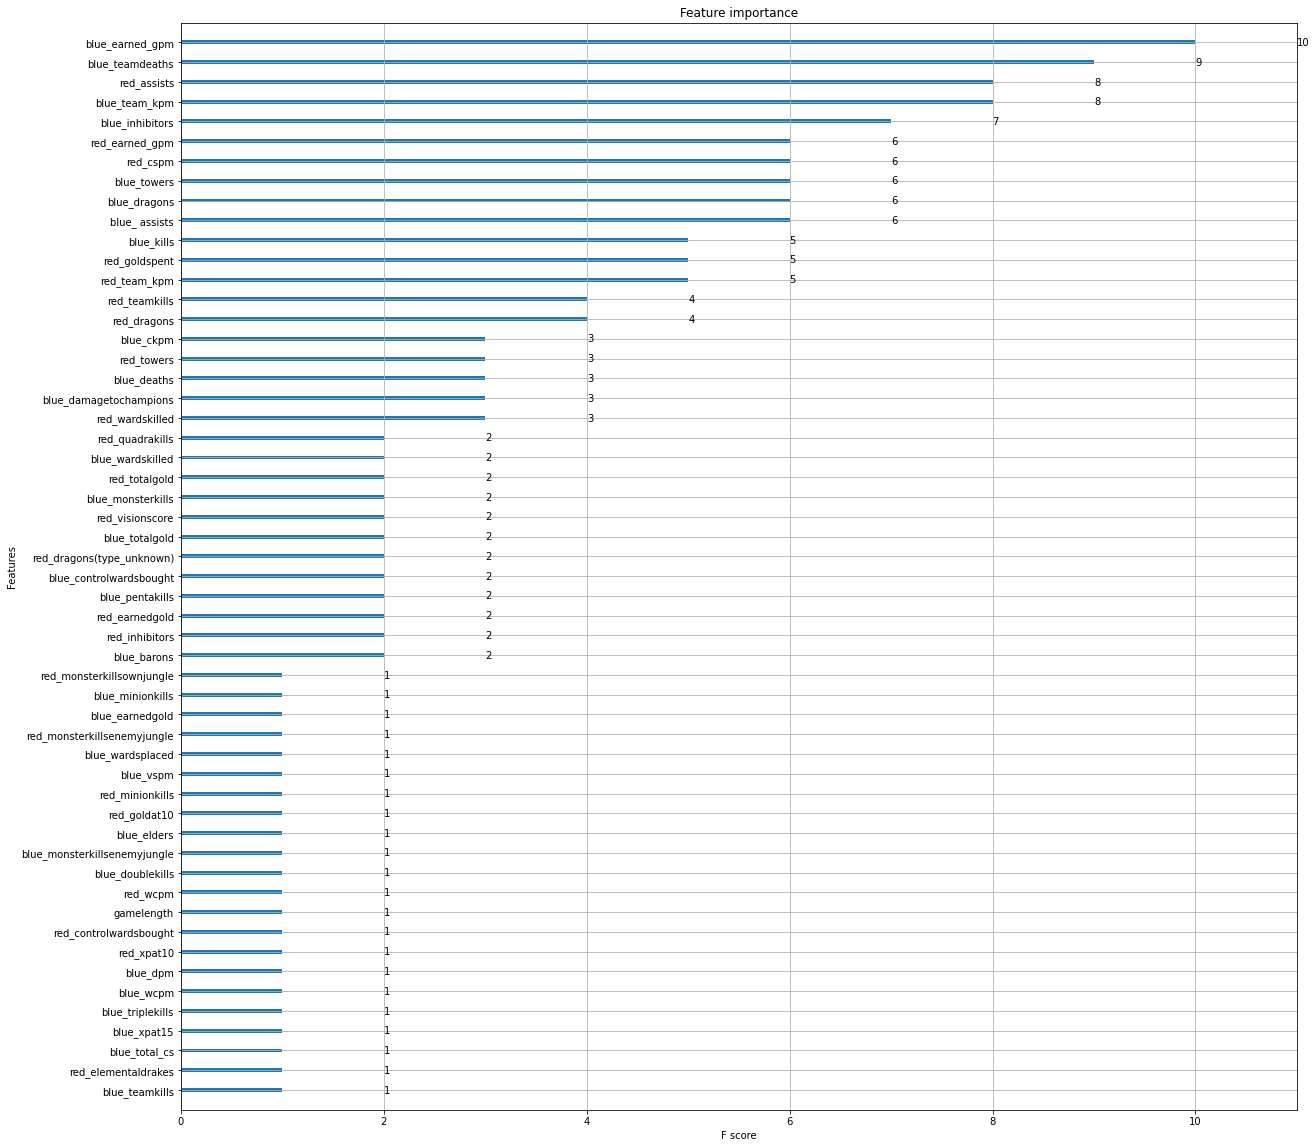

In [162]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [75]:
# imaginando encuentro entre dos equipos, basandonos en el desempeño de estos durante el año en curso----------

In [79]:
# primero vemos que equipos existen en el set
len(set(bluevsred.blue_team))

245

In [80]:
len(set(bluevsred.red_team))

245

In [105]:
set(bluevsred.blue_team)

{'100 Thieves',
 '100 Thieves Academy',
 '1907 Fenerbahçe Academy',
 '1907 Fenerbahçe Esports',
 '5 Ronin',
 '5 Ronin Academy',
 '7more7 Pompa Team',
 'AGO ROGUE',
 'ASUS ROG ELITE',
 'AXIZ',
 'Afreeca Freecs',
 'All Combo',
 'All Knights',
 'Alpha Esports',
 'Asura',
 'Avant Gaming',
 'Awesome Spear',
 'Azules Esports',
 'BT Excel',
 'Berjaya Dragons',
 'Beşiktaş Academy',
 'Beşiktaş Esports',
 'Bilibili Gaming',
 'Bilibili Gaming Junior',
 'Burning Core',
 'CERBERUS Esports',
 'CLG Academy',
 'CR4ZY',
 'Chiefs Academy',
 'Chiefs Esports Club',
 'Cloud9',
 'Cloud9 Academy',
 'Counter Logic Gaming',
 'Crest Gaming Act',
 'CrowCrowd',
 'Cyber Gaming',
 'DAMWON Gaming',
 'DRX',
 'Dark Passage',
 'Dark Passage Academy',
 'Defusekids',
 'DetonatioN FocusMe',
 'Dignitas',
 'Dignitas Academy',
 'Dire Cubs',
 'Dire Wolves',
 'Dominus Esports',
 'Dominus Esports Young',
 'Dragon Army',
 'EDG Youth Team',
 'EDward Gaming',
 'EGN Esports',
 'ESC Shane',
 'EVOS Esports',
 'Electronik Generation',

In [179]:
# se elijen que equipos y lado a jugar
# para el ejemplo "FunPlus Phoenix" lado rojo y 'G2 Esports' lado azul
redteam = bluevsred[(bluevsred.red_team=="FunPlus Phoenix")]
blueteam = bluevsred[(bluevsred.blue_team=="G2 Esports")]

In [180]:
#workflow para tratar ambos sets
redteamnum = redteam._get_numeric_data()
blueteamnum = blueteam._get_numeric_data()
# rellenando nan values
redteamnum.fillna(redteamnum.mean(), inplace=True)
blueteamnum.fillna(blueteamnum.mean(), inplace=True)
# tirando columnas totalmente vacias
redteamnum.dropna(axis=1, how='all', inplace=True)
blueteamnum.dropna(axis=1, how='all', inplace=True)
# change int64 to int 32
redteamnum32 = redteamnum.astype(np.float32)
blueteamnum32 = blueteamnum.astype(np.float32)

In [197]:
# extraemos solo las columnas que tienen caracteristicas de cada equipo
blue_cols_name=list(blueteamnum32.columns)
red_cols_name=list(redteamnum32.columns)

blue_features=[]
for word in blue_cols_name:
    if word.startswith('blue_'):
        blue_features.append(word)
    else:
        pass
        
red_features=[]
for word in red_cols_name:
    if word.startswith('red_'):
        red_features.append(word)
    else:
        pass

In [133]:
# obtenemos stats de datos generales del partido
general_columns_red = redteamnum32[['year', 'playoffs', 'game', 'patch', 'playerid', 'gamelength', 'result']].mean(axis=0).to_frame().T
general_columns_blue = blueteamnum32[['year', 'playoffs', 'game', 'patch', 'playerid', 'gamelength', 'result']].mean(axis=0).to_frame().T
concat_teams = pd.concat([general_columns_red, general_columns_blue],ignore_index=True)
concat_teams = concat_teams.mean(axis=0).to_frame().T
concat_teams

,year,playoffs,game,patch,playerid,gamelength,result
0,2020.0,0.196368,1.657627,10.089272,100.0,1906.087646,0.563196


In [200]:
blueteamnum32 = blueteamnum32[blue_features]
redteamnum32 = redteamnum32[red_features]
blueteamnum32.drop(['blue_gspd', 'blue_golddiffat10', 'blue_xpdiffat10', 'blue_csdiffat10',
       'blue_golddiffat15', 'blue_xpdiffat15', 'blue_csdiffat15'],  axis=1, inplace=True)
blueteamnum32 = blueteamnum32.mean(axis=0).to_frame().T
redteamnum32.drop(['red_gspd','red_golddiffat10', 'red_xpdiffat10', 'red_csdiffat10',
       'red_golddiffat15', 'red_xpdiffat15', 'red_csdiffat15'],  axis=1, inplace=True)
redteamnum32 = redteamnum32.mean(axis=0).to_frame().T

In [201]:
blueteamnum32

,blue_kills,blue_deaths,blue_ assists,blue_teamkills,blue_teamdeaths,blue_doublekills,blue_triplekills,blue_quadrakills,blue_pentakills,blue_firstblood,...,blue_monsterkills,blue_monsterkillsownjungle,blue_monsterkillsenemyjungle,blue_cspm,blue_goldat10,blue_xpat10,blue_csat10,blue_goldat15,blue_xpat15,blue_csat15
0,18.0,13.885715,39.257141,18.0,13.885715,2.114286,0.2,0.028571,0.0,0.685714,...,210.857147,131.028564,25.828571,31.606985,15619.588867,17841.029297,308.823547,25339.792969,28648.058594,487.26474


In [202]:
redteamnum32

,red_deaths,red_assists,red_teamkills,red_teamdeaths,red_doublekills,red_triplekills,red_quadrakills,red_pentakills,red_firstblood,red_team_kpm,...,red_monsterkills,red_monsterkillsownjungle,red_monsterkillsenemyjungle,red_cspm,red_goldat10,red_xpat10,red_csat10,red_goldat15,red_xpat15,red_csat15
0,12.254237,33.169491,13.644068,12.254237,1.603448,0.293103,0.086207,0.034483,0.576271,0.432415,...,209.745758,138.881363,16.508474,30.482168,15765.654297,18049.550781,309.655151,25094.050781,28920.449219,495.93103


In [205]:
simulate_match = pd.concat([concat_teams,blueteamnum32,redteamnum32], axis = 1)
simulate_match

,year,playoffs,game,patch,playerid,gamelength,result,blue_kills,blue_deaths,blue_ assists,...,red_monsterkills,red_monsterkillsownjungle,red_monsterkillsenemyjungle,red_cspm,red_goldat10,red_xpat10,red_csat10,red_goldat15,red_xpat15,red_csat15
0,2020.0,0.196368,1.657627,10.089272,100.0,1906.087646,0.563196,18.0,13.885715,39.257141,...,209.745758,138.881363,16.508474,30.482168,15765.654297,18049.550781,309.655151,25094.050781,28920.449219,495.93103


In [208]:
list(simulate_match.columns)

['year',
 'playoffs',
 'game',
 'patch',
 'playerid',
 'gamelength',
 'result',
 'blue_kills',
 'blue_deaths',
 'blue_ assists',
 'blue_teamkills',
 'blue_teamdeaths',
 'blue_doublekills',
 'blue_triplekills',
 'blue_quadrakills',
 'blue_pentakills',
 'blue_firstblood',
 'blue_team_kpm',
 'blue_ckpm',
 'blue_firstdragon',
 'blue_dragons',
 'blue_elementaldrakes',
 'blue_infernals',
 'blue_mountains',
 'blue_clouds',
 'blue_oceans',
 'blue_dragons(type_unknown)',
 'blue_elders',
 'blue_firstherald',
 'blue_heralds',
 'blue_firstbaron',
 'blue_barons',
 'blue_firsttower',
 'blue_towers',
 'blue_firstmidtower',
 'blue_firsttothreetowers',
 'blue_inhibitors',
 'blue_damagetochampions',
 'blue_dpm',
 'blue_wardsplaced',
 'blue_wpm',
 'blue_wardskilled',
 'blue_wcpm',
 'blue_controlwardsbought',
 'blue_visionscore',
 'blue_vspm',
 'blue_totalgold',
 'blue_earnedgold',
 'blue_earned_gpm',
 'blue_goldspent',
 'blue_minionkills',
 'blue_monsterkills',
 'blue_monsterkillsownjungle',
 'blue_monst

In [148]:
#-----------------------------------------PUEDE QUE ESTE BLOQUE SOBRE-----------------------
# quitamos la columnas que se quitaron en el entrenamiento del modelo
simulate_match = simulate_match.drop(['result', 'year', 'playoffs','blue_gspd', 'blue_golddiffat10', 'blue_xpdiffat10', 'blue_csdiffat10',
       'blue_golddiffat15', 'blue_xpdiffat15', 'blue_csdiffat15', 'red_gspd',
       'red_golddiffat10', 'red_xpdiffat10', 'red_csdiffat10',
       'red_golddiffat15', 'red_xpdiffat15', 'red_csdiffat15'], axis = 1)

In [150]:
type(simulate_match)

pandas.core.frame.DataFrame

In [204]:
preds_game = xg_reg.predict(simulate_match)

ValueError: feature_names mismatch: ['game', 'patch', 'playerid', 'gamelength', 'blue_kills', 'blue_deaths', 'blue_ assists', 'blue_teamkills', 'blue_teamdeaths', 'blue_doublekills', 'blue_triplekills', 'blue_quadrakills', 'blue_pentakills', 'blue_firstblood', 'blue_team_kpm', 'blue_ckpm', 'blue_firstdragon', 'blue_dragons', 'blue_elementaldrakes', 'blue_infernals', 'blue_mountains', 'blue_clouds', 'blue_oceans', 'blue_dragons(type_unknown)', 'blue_elders', 'blue_firstherald', 'blue_heralds', 'blue_firstbaron', 'blue_barons', 'blue_firsttower', 'blue_towers', 'blue_firstmidtower', 'blue_firsttothreetowers', 'blue_inhibitors', 'blue_damagetochampions', 'blue_dpm', 'blue_wardsplaced', 'blue_wpm', 'blue_wardskilled', 'blue_wcpm', 'blue_controlwardsbought', 'blue_visionscore', 'blue_vspm', 'blue_totalgold', 'blue_earnedgold', 'blue_earned_gpm', 'blue_goldspent', 'blue_total_cs', 'blue_minionkills', 'blue_monsterkills', 'blue_monsterkillsownjungle', 'blue_monsterkillsenemyjungle', 'blue_cspm', 'blue_goldat10', 'blue_xpat10', 'blue_csat10', 'blue_goldat15', 'blue_xpat15', 'blue_csat15', 'red_deaths', 'red_assists', 'red_teamkills', 'red_teamdeaths', 'red_doublekills', 'red_triplekills', 'red_quadrakills', 'red_pentakills', 'red_firstblood', 'red_team_kpm', 'red_ckpm', 'red_firstdragon', 'red_dragons', 'red_elementaldrakes', 'red_infernals', 'red_mountains', 'red_clouds', 'red_oceans', 'red_dragons(type_unknown)', 'red_elders', 'red_firstherald', 'red_heralds', 'red_firstbaron', 'red_barons', 'red_firsttower', 'red_towers', 'red_firstmidtower', 'red_firsttothreetowers', 'red_inhibitors', 'red_damagetochampions', 'red_dpm', 'red_wardsplaced', 'red_wpm', 'red_wardskilled', 'red_wcpm', 'red_controlwardsbought', 'red_visionscore', 'red_vspm', 'red_totalgold', 'red_earnedgold', 'red_earned_gpm', 'red_goldspent', 'red_total_cs', 'red_minionkills', 'red_monsterkills', 'red_monsterkillsownjungle', 'red_monsterkillsenemyjungle', 'red_cspm', 'red_goldat10', 'red_xpat10', 'red_csat10', 'red_goldat15', 'red_xpat15', 'red_csat15'] ['year', 'playoffs', 'game', 'patch', 'playerid', 'gamelength', 'result', 'blue_kills', 'blue_deaths', 'blue_ assists', 'blue_teamkills', 'blue_teamdeaths', 'blue_doublekills', 'blue_triplekills', 'blue_quadrakills', 'blue_pentakills', 'blue_firstblood', 'blue_team_kpm', 'blue_ckpm', 'blue_firstdragon', 'blue_dragons', 'blue_elementaldrakes', 'blue_infernals', 'blue_mountains', 'blue_clouds', 'blue_oceans', 'blue_dragons(type_unknown)', 'blue_elders', 'blue_firstherald', 'blue_heralds', 'blue_firstbaron', 'blue_barons', 'blue_firsttower', 'blue_towers', 'blue_firstmidtower', 'blue_firsttothreetowers', 'blue_inhibitors', 'blue_damagetochampions', 'blue_dpm', 'blue_wardsplaced', 'blue_wpm', 'blue_wardskilled', 'blue_wcpm', 'blue_controlwardsbought', 'blue_visionscore', 'blue_vspm', 'blue_totalgold', 'blue_earnedgold', 'blue_earned_gpm', 'blue_goldspent', 'blue_minionkills', 'blue_monsterkills', 'blue_monsterkillsownjungle', 'blue_monsterkillsenemyjungle', 'blue_cspm', 'blue_goldat10', 'blue_xpat10', 'blue_csat10', 'blue_goldat15', 'blue_xpat15', 'blue_csat15', 'red_deaths', 'red_assists', 'red_teamkills', 'red_teamdeaths', 'red_doublekills', 'red_triplekills', 'red_quadrakills', 'red_pentakills', 'red_firstblood', 'red_team_kpm', 'red_ckpm', 'red_firstdragon', 'red_dragons', 'red_elementaldrakes', 'red_infernals', 'red_mountains', 'red_clouds', 'red_oceans', 'red_dragons(type_unknown)', 'red_elders', 'red_firstherald', 'red_heralds', 'red_firstbaron', 'red_barons', 'red_firsttower', 'red_towers', 'red_firstmidtower', 'red_firsttothreetowers', 'red_inhibitors', 'red_damagetochampions', 'red_dpm', 'red_wardsplaced', 'red_wpm', 'red_wardskilled', 'red_wcpm', 'red_controlwardsbought', 'red_visionscore', 'red_vspm', 'red_totalgold', 'red_earnedgold', 'red_earned_gpm', 'red_goldspent', 'red_total_cs', 'red_minionkills', 'red_monsterkills', 'red_monsterkillsownjungle', 'red_monsterkillsenemyjungle', 'red_cspm', 'red_goldat10', 'red_xpat10', 'red_csat10', 'red_goldat15', 'red_xpat15', 'red_csat15']
expected blue_total_cs in input data
training data did not have the following fields: playoffs, year, result

In [152]:
xg_reg

In [ ]:
#simulate_match revisar columnas, que sean iguales a las columnas qeu use de entrenamiento